In [44]:
using DiffEQ
using PyPlot

In [2]:
type HPParam
    a1::Float64
    a2::Float64
    b1::Float64
    b2::Float64
    d1::Float64
    d2::Float64
end

The default parameters set with $b_1 = 3.0$

In [3]:
param = HPParam(5.0, 0.1, 3.0, 2.0, 0.4, 0.01)

HPParam(5.0,0.1,3.0,2.0,0.4,0.01)

In [4]:
function model(t, y, par::HPParam)
    yprime = zeros(3)
    yprime[1] = y[1]*(1.0 - y[1]) - par.a1*y[1]*y[2]/(1.0 + par.b1*y[1])
    yprime[2] = par.a1*y[1]*y[2]/(1.0 + par.b1*y[1]) - par.a2*y[2]*y[3]/(1.0 + par.b2*y[2]) - par.d1*y[2]
    yprime[3] = par.a2*y[2]*y[3]/(1.0 + par.b2*y[2]) - par.d2*y[3]
    return yprime
end

model (generic function with 1 method)

In [5]:
sol = aode(Dopri54((t, x) -> model(t, x, param), [0.8, 0.2, 10.0]), 0.0:10000);
# small perturburbation to initial conditions
sol_div = aode(Dopri54((t, x) -> model(t, x, param), [0.81, 0.21, 10.1]), 0.0:10000);

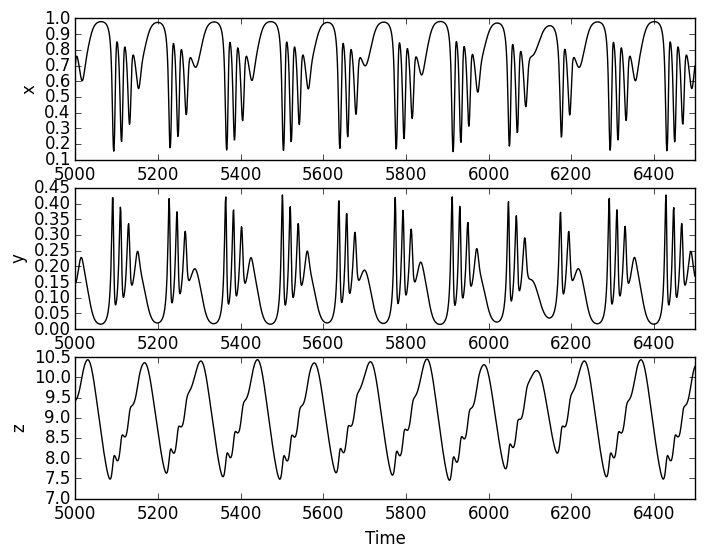

In [17]:
#TODO: clean up the ugly y-axis labelling
subplot(311)
plot(sol.x[5000:6500], sol.y[5000:6500, 1], "k")
xlim(5000, 6500)
ylabel("x")
subplot(312)
plot(sol.x[5000:6500], sol.y[5000:6500, 2], "k")
xlim(5000, 6500)
ylabel("y")
subplot(313)
plot(sol.x[5000:6500], sol.y[5000:6500, 3], "k")
xlim(5000, 6500)
xlabel("Time")
ylabel("z");

I don't know how to show the 3D *teacup* attractor as I need a 3D plotting package which `Gadfly.jl` doesn't support

Now we look at how small perturbations to the initial conditions lead to significant changes in the schape of the solution.

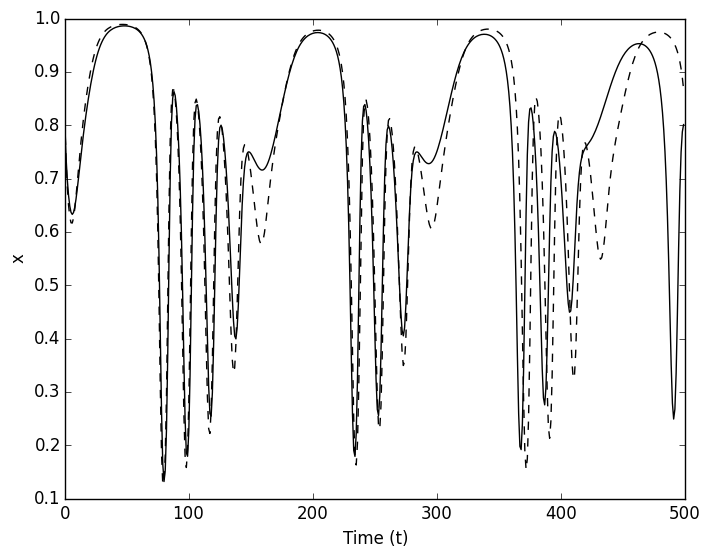

In [23]:
plot(sol.x[1:500], sol.y[1:500, 1], "k")
plot(sol_div.x[1:500], sol_div.y[1:500, 1], "k--")
xlabel("Time (t)")
ylabel("x");

## Bifurcation Analysis

Following the authors we will look at the local maxes for the last 5000 points (5000:10000) for changes in $b_1$ between 2.0 and 3.2 in steps of 0.01

In [24]:
function local_max(ts::AbstractVector{Float64})
    lmaxs = Float64[]
    for i in 2:(length(ts) - 3)
        if ts[i - 1] < ts[i] && ts[i] > ts[i + 1]
            push!(lmaxs, ts[i])
        end
    end
    return lmaxs
end

local_max (generic function with 1 method)

In [25]:
##TODO: if I explictly use the "ExplicitRungeKutta" method in Mathematica this code is around 64sec/24sec = 2.6 times faster
## make this a benchmark problem. Now if I use the ParallelTable for solving the ODE I can get it so that Mathematica
## is 24/22 = 1.09 times faster. Still this is crushing ... and require that I use a C compiler for the localMax function.
function bif_analysis(b1vals)
    bparam = HPParam(5.0, 0.1, 3.0, 2.0, 0.4, 0.01)
    system = Dopri54((t, y) -> model(t, y, bparam), [0.8, 0.2, 10.0])
    # the number of local maxes varies so we need a ragged array
    bpoints = []
    for b1 in b1vals
        # since mutable types are passed by reference this just works :)
        bparam.b1 = b1
        bsol = aode(system, 0.0:10000)
        for m in local_max(bsol.y[5000:10000, 3])
            push!(bpoints, [b1, m])
        end
    end
    return bpoints
end

bif_analysis (generic function with 1 method)

In [26]:
@time bpoints = bif_analysis(2.2:0.001:3.2);

In [27]:
bpoints = hcat(bpoints...)';

23.617660 seconds (628.45 M allocations: 16.923 GB, 7.34% gc time)


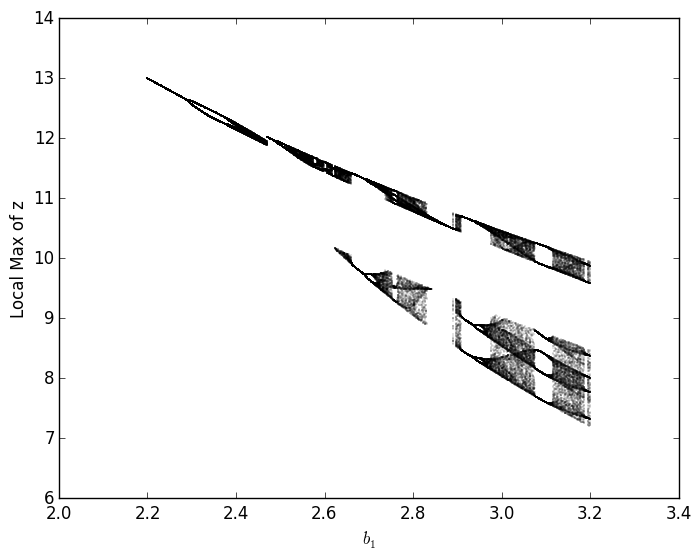

In [37]:
scatter(bpoints[:, 1], bpoints[:, 2], s = 0.005)
xlabel(L"b_1")
ylabel("Local Max of z");

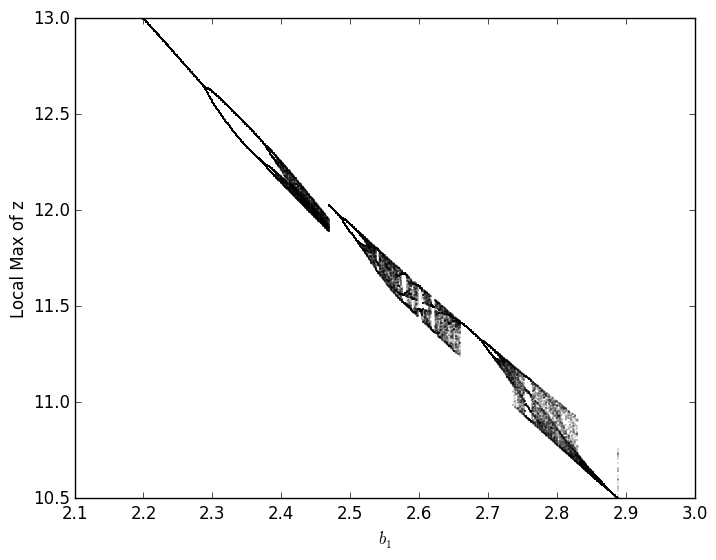

In [43]:
scatter(bpoints[1:50000, 1], bpoints[1:50000, 2], s = 0.008)
ylim(10.5, 13)
xlabel(L"b_1")
ylabel("Local Max of z");